In [1]:
# Import libraries for ML pipeline
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os

# Download NLTK resources
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

# Purpose: Set up libraries for preprocessing (NLTK, re), feature engineering (TfidfVectorizer),
# model training/evaluation (sklearn), and visualization (matplotlib, seaborn).
# ML Concept: Environment setup for a robust pipeline.

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
# Load datasets (subsample df5 to 10% for memory efficiency)
df1 = pd.read_csv('D:\\Projects\\Sentiment Analysis\\dataset\\sentiment_analysis.csv', encoding='latin1')
df2 = pd.read_csv('D:\\Projects\\Sentiment Analysis\\dataset\\test.csv', encoding='latin1')
df3 = pd.read_csv('D:\\Projects\\Sentiment Analysis\\dataset\\testdata.manual.2009.06.14.csv', encoding='latin1')
df4 = pd.read_csv('D:\\Projects\\Sentiment Analysis\\dataset\\train.csv', encoding='latin1')
df5 = pd.read_csv('D:\\Projects\\Sentiment Analysis\\dataset\\training.1600000.processed.noemoticon.csv', encoding='latin1').sample(frac=0.1, random_state=42)
df6 = pd.read_csv('D:\\Projects\\Sentiment Analysis\\dataset\\twitter_training.csv', encoding='latin1')
df7 = pd.read_csv('D:\\Projects\\Sentiment Analysis\\dataset\\twitter_validation.csv', encoding='latin1')


# Standardize column names and sentiment labels
df1 = df1[['text', 'sentiment']].copy()
df2 = df2[['text', 'sentiment']].copy()
df3.columns = ['sentiment', 'id', 'date', 'query', 'user', 'text']
df3['sentiment'] = df3['sentiment'].map({4: 'positive', 0: 'negative', 2: 'neutral'})
df3 = df3[['text', 'sentiment']].copy()
df4 = df4[['text', 'sentiment']].copy()
df5.columns = ['sentiment', 'id', 'date', 'query', 'user', 'text']
df5['sentiment'] = df5['sentiment'].map({4: 'positive', 0: 'negative', 2: 'neutral'})
df5 = df5[['text', 'sentiment']].copy()
df6.columns = ['id', 'entity', 'sentiment', 'text']
df6['sentiment'] = df6['sentiment'].map({'Positive': 'positive', 'Negative': 'negative', 'Neutral': 'neutral', 'Irrelevant': 'neutral'})
df6 = df6[['text', 'sentiment']].copy()
df7.columns = ['id', 'entity', 'sentiment', 'text']
df7['sentiment'] = df7['sentiment'].map({'Positive': 'positive', 'Negative': 'negative', 'Neutral': 'neutral', 'Irrelevant': 'neutral'})
df7 = df7[['text', 'sentiment']].copy()

# Combine datasets
combined_df = pd.concat([df1, df2, df3, df4, df5, df6, df7], ignore_index=True)

# Remove rows with missing text or sentiment
combined_df.dropna(subset=['text', 'sentiment'], inplace=True)

# Convert text to string
combined_df['text'] = combined_df['text'].astype(str)

# Filter valid sentiments
valid_sentiments = ['positive', 'negative', 'neutral']
combined_df = combined_df[combined_df['sentiment'].isin(valid_sentiments)].copy()

# Purpose: Load, standardize, and combine datasets, ensuring memory efficiency with subsampling.
# ML Concept: Data collection and cleaning, handling missing values and class consistency.

In [3]:
# Initialize NLTK tools
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Clean text: lowercase, remove URLs, special characters, emojis, tokenize, remove stop words, lemmatize
cleaned_texts = []
for text in combined_df['text']:
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)  # Remove URLs
    text = re.sub(r'[^a-z\s]', '', text)  # Remove special chars and numbers
    text = re.sub(r'[^\x00-\x7F]+', '', text)  # Remove emojis
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    cleaned_text = ' '.join(tokens)
    cleaned_texts.append(cleaned_text if cleaned_text.strip() else 'unknown')  # Handle empty texts

# Update DataFrame
combined_df['cleaned_text'] = cleaned_texts
combined_df = combined_df[combined_df['cleaned_text'] != 'unknown'].copy()

# Purpose: Preprocess text to standardize and reduce noise for feature extraction.
# ML Concept: Text preprocessing for NLP, improving feature quality.

In [4]:
# Initialize TF-IDF vectorizer
vectorizer = TfidfVectorizer(max_features=5000, lowercase=False)

# Fit and transform cleaned text
X = vectorizer.fit_transform(combined_df['cleaned_text'])

# Encode labels
y = combined_df['sentiment'].map({'positive': 0, 'negative': 1, 'neutral': 2}).values

# Purpose: Convert text to TF-IDF features with a limited vocabulary size.
# ML Concept: Feature engineering, transforming raw text into numerical features.

In [5]:
# Split data into training (80%) and testing (20%) sets with stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Purpose: Split data for training and evaluation, maintaining class proportions.
# ML Concept: Train-test split with stratification to ensure balanced classes.

In [6]:
# Initialize logistic regression model
model = LogisticRegression(multi_class='multinomial', max_iter=1000, random_state=42)

# Perform 5-fold cross-validation
cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')

print(f"5-Fold Cross-Validation Accuracy: Mean = {cv_scores.mean():.4f}, Std = {cv_scores.std():.4f}")
print("Individual Fold Scores:", cv_scores)

# Purpose: Assess model stability and generalization using cross-validation.
# ML Concept: Cross-validation to evaluate model performance on unseen data.

C:\Users\ASUS\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\ASUS\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\ASUS\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\ASUS\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\

5-Fold Cross-Validation Accuracy: Mean = 0.6952, Std = 0.0014
Individual Fold Scores: [0.69430977 0.69612422 0.69433951 0.69740325 0.6938041 ]


In [7]:
# Define hyperparameter grid
param_grid = {
    'C': [0.1, 1.0, 10.0],
    'solver': ['lbfgs', 'saga']
}

# Initialize grid search
grid_search = GridSearchCV(LogisticRegression(multi_class='multinomial', max_iter=1000, random_state=42),
                           param_grid, cv=3, scoring='accuracy', n_jobs=-1)

# Fit grid search
grid_search.fit(X_train, y_train)

# Best parameters and score
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Cross-Validation Accuracy: {grid_search.best_score_:.4f}")

# Update model with best parameters
model = grid_search.best_estimator_

# Purpose: Optimize model hyperparameters to improve performance.
# ML Concept: Hyperparameter tuning via grid search with cross-validation.

C:\Users\ASUS\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Best Parameters: {'C': 1.0, 'solver': 'saga'}
Best Cross-Validation Accuracy: 0.6935


C:\Users\ASUS\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



Test Accuracy: 0.6984
Macro Precision: 0.6721
Macro Recall: 0.6190
Macro F1-Score: 0.6345

Per-Class Metrics (positive, negative, neutral):
Precision: [0.65510836 0.72777674 0.63344565]
Recall: [0.57401212 0.87289392 0.41019752]
F1-Score: [0.61188491 0.79375715 0.49794382]

Classification Report:
              precision    recall  f1-score   support

    positive       0.66      0.57      0.61     11059
    negative       0.73      0.87      0.79     22257
     neutral       0.63      0.41      0.50      8708

    accuracy                           0.70     42024
   macro avg       0.67      0.62      0.63     42024
weighted avg       0.69      0.70      0.68     42024



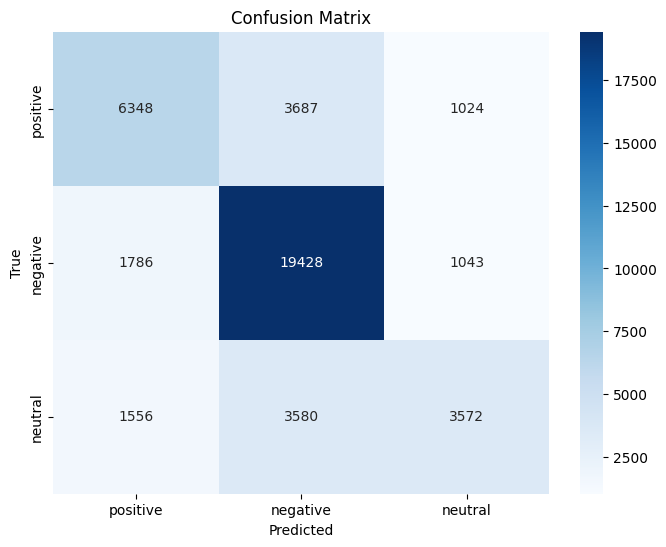

In [8]:
# Train the model on full training data
model.fit(X_train, y_train)

# Predict on test set
y_pred = model.predict(X_test)

# Compute evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='macro')
per_class_metrics = precision_recall_fscore_support(y_test, y_pred)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
labels = ['positive', 'negative', 'neutral']

# Print metrics
print(f"\nTest Accuracy: {accuracy:.4f}")
print(f"Macro Precision: {precision:.4f}")
print(f"Macro Recall: {recall:.4f}")
print(f"Macro F1-Score: {f1:.4f}")
print("\nPer-Class Metrics (positive, negative, neutral):")
print(f"Precision: {per_class_metrics[0]}")
print(f"Recall: {per_class_metrics[1]}")
print(f"F1-Score: {per_class_metrics[2]}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=labels))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Purpose: Train the model, evaluate performance, and visualize results.
# ML Concept: Model training, evaluation with multiple metrics, and visualization.

In [9]:
# Save model and vectorizer
with open('logistic_model.pkl', 'wb') as f:
    pickle.dump(model, f)
with open('tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)

print("Model saved to 'logistic_model.pkl'")
print("TF-IDF vectorizer saved to 'tfidf_vectorizer.pkl'")

# Purpose: Save trained model and vectorizer for future predictions.
# ML Concept: Model persistence for deployment or reuse.

Model saved to 'logistic_model.pkl'
TF-IDF vectorizer saved to 'tfidf_vectorizer.pkl'


In [10]:
# Initialize NLTK tools
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Example input text
custom_text = "I love this movie, it's absolutely fantastic!"

# Preprocess input text
text = custom_text.lower()
text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
text = re.sub(r'[^a-z\s]', '', text)
text = re.sub(r'[^\x00-\x7F]+', '', text)
tokens = word_tokenize(text)
tokens = [word for word in tokens if word not in stop_words]
tokens = [lemmatizer.lemmatize(word) for word in tokens]
cleaned_text = ' '.join(tokens)

# Transform text to TF-IDF
X_new = vectorizer.transform([cleaned_text])

# Predict sentiment
y_pred_new = model.predict(X_new)
y_prob_new = model.predict_proba(X_new)

# Map prediction to label
idx_to_label = {0: 'positive', 1: 'negative', 2: 'neutral'}
predicted_sentiment = idx_to_label[y_pred_new[0]]

print(f"\nInput Text: {custom_text}")
print(f"Predicted Sentiment: {predicted_sentiment}")
print(f"Prediction Probabilities (positive, negative, neutral): {y_prob_new[0]}")

# Purpose: Predict sentiment on new text using the trained model.
# ML Concept: Model inference on unseen data.


Input Text: I love this movie, it's absolutely fantastic!
Predicted Sentiment: positive
Prediction Probabilities (positive, negative, neutral): [0.86473571 0.03279495 0.10246934]


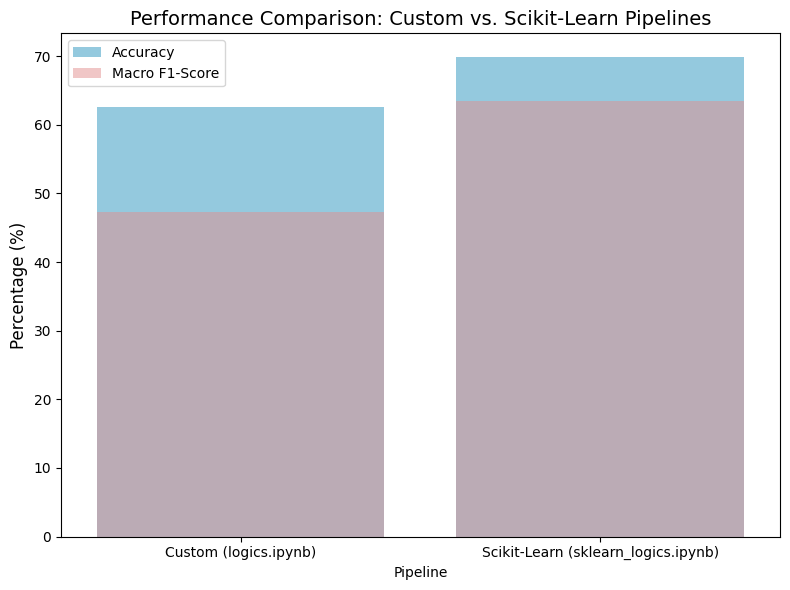

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Data
data = {
    'Pipeline': ['Custom (logics.ipynb)', 'Scikit-Learn (sklearn_logics.ipynb)'],
    'Accuracy': [62.65, 69.84],
    'Macro F1-Score': [47.30, 63.45]
}
df = pd.DataFrame(data)

# Plot
plt.figure(figsize=(8, 6))
sns.barplot(x='Pipeline', y='Accuracy', data=df, color='skyblue', label='Accuracy')
sns.barplot(x='Pipeline', y='Macro F1-Score', data=df, color='lightcoral', label='Macro F1-Score', alpha=0.5)
plt.title('Performance Comparison: Custom vs. Scikit-Learn Pipelines', fontsize=14)
plt.ylabel('Percentage (%)', fontsize=12)
plt.legend()
plt.tight_layout()
plt.savefig('pipeline_comparison.png', dpi=300)
plt.show()

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


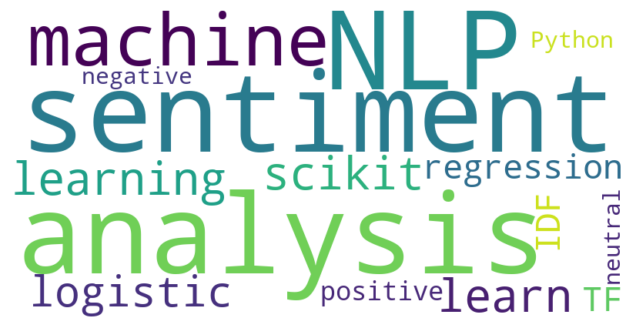

In [13]:
%pip install wordcloud

from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Sample words related to sentiment analysis
words = "sentiment analysis NLP machine learning scikit-learn logistic regression TF-IDF positive negative neutral Python"
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(words)

# Plot
plt.figure(figsize=(8, 4))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.savefig('sentiment_wordcloud.png', dpi=300)
plt.show()